In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [3]:
pas="1"
config="3"
#Q2nominal=6.83

In [177]:
hodo=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hodo1.npz")
trigger=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/trigger1.npz")
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/generic1.npz")
hcal=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hcal1.npz")
sim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{config}/simulation0.npz")
print(hodo.files)
print(trigger.files)
print(generic.files)
print(hcal.files)
print(sim.files)

['hodoTimes', 'hodoIDs', 'hodoTOT', 'nbars', 'hodoClusMean']
['trigger', 'triggerID', 'NdataTriggerID']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'coin_time']
['cblkid', 'cblkatime', 'cblktime', 'cblke', 'nclus', 'cid', 'cx', 'cy', 'catime']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP']


# Weird discrepancy

In [239]:
ePS=sim['ePS']
eSH=sim['eSH']
trP=sim['trP']
etheta=sim['etheta']

In [240]:
evsangle=plt.hist2d(etheta*180/math.pi,np.sqrt(.000511**2+trP**2),bins=((100,100)),range=((30,45),(1,4)),cmap="cividis")

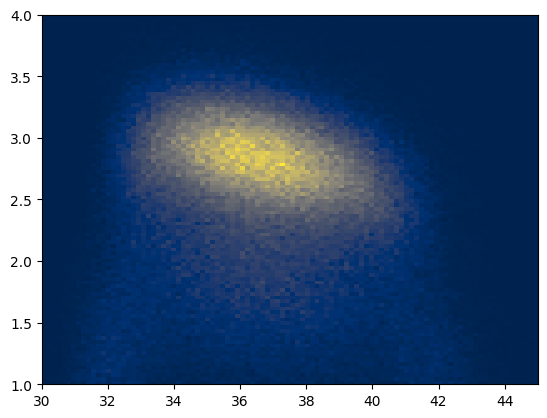

In [241]:
evsangle=plt.hist2d(etheta*180/math.pi,ePS+eSH,bins=((100,100)),range=((30,45),(1,4)),cmap="cividis")

# Fitting ellipse from sim

In [242]:
evsangle=plt.hist2d(etheta*180/math.pi,np.sqrt(.000511**2+trP**2),bins=((100,100)),range=((28,45),(2,3.5)),cmap="cividis")

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    x_prime = (x - xo) * np.cos(theta) + (y - yo) * np.sin(theta)
    y_prime = -(x - xo) * np.sin(theta) + (y - yo) * np.cos(theta)
    g = offset + amplitude * np.exp(
        -((x_prime ** 2) / (2 * sigma_x ** 2) + (y_prime ** 2) / (2 * sigma_y ** 2))
    )
    return g.ravel()

# Generate grid for histogram bin centers
x_edges = np.linspace(28, 45, 101)
y_edges = np.linspace(2, 3.5, 101)
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Extract histogram data from `evsangle`
hist_data = evsangle[0]  # Your 2D histogram data
X, Y = np.meshgrid(x_centers, y_centers)

# Flatten the histogram and grid data
x_data = X.ravel()
y_data = Y.ravel()
z_data = hist_data.T.ravel()

# Initial guess for Gaussian parameters
initial_guess = (
    z_data.max(),  # amplitude
    np.mean(x_centers),  # x0
    np.mean(y_centers),  # y0
    np.std(x_centers),  # sigma_x
    np.std(y_centers),  # sigma_y
    0,  # theta (rotation angle)
    0,  # offset
)

# Fit the 2D Gaussian to the histogram data
popt, _ = curve_fit(
    gaussian_2d,
    (x_data, y_data),
    z_data,
    p0=initial_guess,
    maxfev=10000,
)

# Extract fitted parameters
amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt

# Generate the fitted Gaussian for plotting
z_fit = gaussian_2d((x_data, y_data), *popt).reshape(X.shape)

# Plot original histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(hist_data.T, origin='lower', extent=(28, 45, 2, 3.5), cmap="cividis", aspect="auto")
ax.set_title("2D Gaussian Fit")
ax.set_xlabel(r"$\theta$ (degrees)")
ax.set_ylabel(r"$\sqrt{p^2 + m^2}$")

# Overlay the fitted Gaussian
contour = ax.contour(X, Y, z_fit, levels=5, colors='red', linewidths=1.5)
plt.show()



$
G(x, y) = A \exp\left(-\frac{1}{2} \left[ \frac{(x - x_0)^2}{\sigma_x^2} + \frac{(y - y_0)^2}{\sigma_y^2} \right] \right) + C
$

$
R^2 = \frac{(x - x_0)^2}{\sigma_x^2} + \frac{(y - y_0)^2}{\sigma_y^2}
$


$
G(x, y) = A \exp\left(-\frac{1}{2} R^2\right) + C
$

$
G(x, y) = A \exp\left(-\frac{1}{2} \cdot 9\right) + C
$

$
G(x, y) = A \exp(-4.5) + C
$


$
\exp(-4.5) \approx 0.0111
$


G(x, y) = A \cdot 0.0111 + C
$



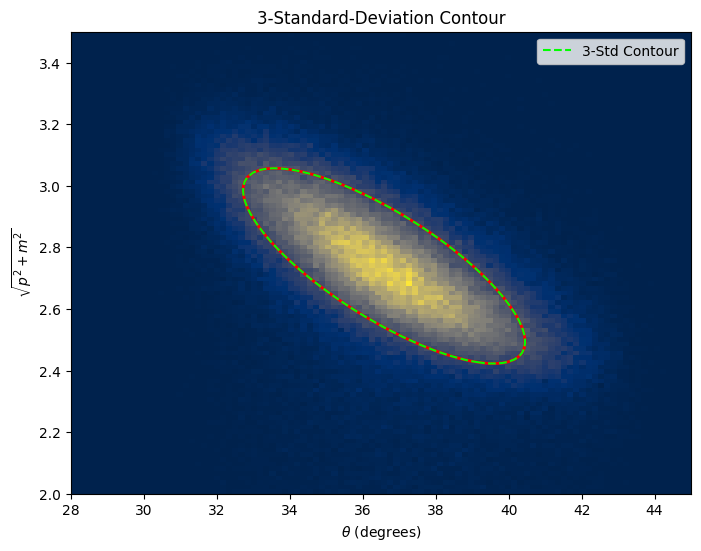

In [273]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Define the 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    x_prime = (x - xo) * np.cos(theta) + (y - yo) * np.sin(theta)
    y_prime = -(x - xo) * np.sin(theta) + (y - yo) * np.cos(theta)
    g = offset + amplitude * np.exp(
        -((x_prime**2) / (2 * sigma_x**2) + (y_prime**2) / (2 * sigma_y**2))
    )
    return g.ravel()

# Generate the 2D Gaussian fit
x_edges = np.linspace(28, 45, 101)
y_edges = np.linspace(2, 3.5, 101)
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

hist_data = evsangle[0]  # Your 2D histogram data
X, Y = np.meshgrid(x_centers, y_centers)

# Flatten data for fitting
x_data = X.ravel()
y_data = Y.ravel()
z_data = hist_data.T.ravel()

# Initial guess for Gaussian parameters
initial_guess = (
    z_data.max(),  # amplitude
    np.mean(x_centers),  # x0
    np.mean(y_centers),  # y0
    np.std(x_centers),  # sigma_x
    np.std(y_centers),  # sigma_y
    0,  # theta
    0,  # offset
)

# Fit the data
popt, _ = curve_fit(
    gaussian_2d,
    (x_data, y_data),
    z_data,
    p0=initial_guess,
    maxfev=10000,
)

# Extract fitted parameters
amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt

# Generate the fitted Gaussian
z_fit = gaussian_2d((x_data, y_data), *popt).reshape(X.shape)

# Calculate the 3-standard-deviation threshold

#
threshold_3std = offset + amplitude * np.exp(math.log(.28))  # 3 standard deviations

# Plot the histogram and 3-std contour
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(hist_data.T, origin='lower', extent=(28, 45, 2, 3.5), cmap="cividis", aspect="auto")
ax.set_title("3-Standard-Deviation Contour")
ax.set_xlabel(r"$\theta$ (degrees)")
ax.set_ylabel(r"$\sqrt{p^2 + m^2}$")

# Add the 3-std contour
contour = ax.contour(X, Y, z_fit, levels=[threshold_3std], colors='red', linewidths=2)

# Extract the vertices of the 3-std contour
contour_path = contour.collections[0].get_paths()[0]
contour_vertices = contour_path.vertices

# Optionally overlay the vertices
ax.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'lime', linestyle='--', label='3-Std Contour')

# Add legend
ax.legend()
plt.show()

# The 3-standard-deviation contour vertices are stored in `contour_vertices`


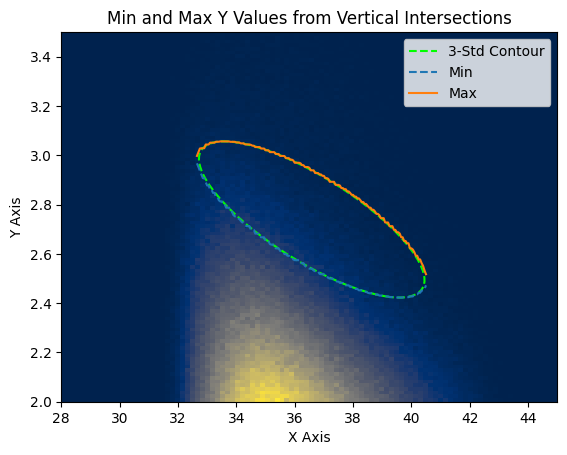

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the contour vertices
x_vertices = contour_vertices[:, 0]
y_vertices = contour_vertices[:, 1]

# Define the x-axis steps
x_steps = np.arange(28, 45.1, 0.05)  # Adjust range if necessary

# Initialize lists for min and max y-values
y_min = []
y_max = []
angles=[]
# Find intersections of vertical lines with the contour
for x in x_steps:
    # Find all vertices close to the current x value
    intersections = y_vertices[np.isclose(x_vertices, x, atol=.09)]  # Adjust atol as needed
    if len(intersections) >= 2:  # Ensure there are at least two intersections
        angles.append(x)
        y_min.append(np.min(intersections))
        y_max.append(np.max(intersections))
    else:
        f=3

# Create a DataFrame for the results
boundary_df = pd.DataFrame({
    "angles": angles,
    "y_min": y_min,
    "y_max": y_max
})
evsangle=plt.hist2d(etheta*180/math.pi,np.sqrt(.000511**2+trP**2),bins=((100,100)),range=((28,45),(2,3.5)),cmap="cividis")
plt.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'lime', linestyle='--', label='3-Std Contour')

# Plot the results
#plt.figure(figsize=(8, 6))
plt.plot(boundary_df["angles"], boundary_df["y_min"], label="Min", linestyle="--")
plt.plot(boundary_df["angles"], boundary_df["y_max"], label="Max")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Min and Max Y Values from Vertical Intersections")
plt.legend()
plt.show()

# Optionally, save the DataFrame to a CSV for further analysis
boundary_df.to_csv("angleEnergy.csv", index=False)


Text(0, 0.5, 'Energy ')

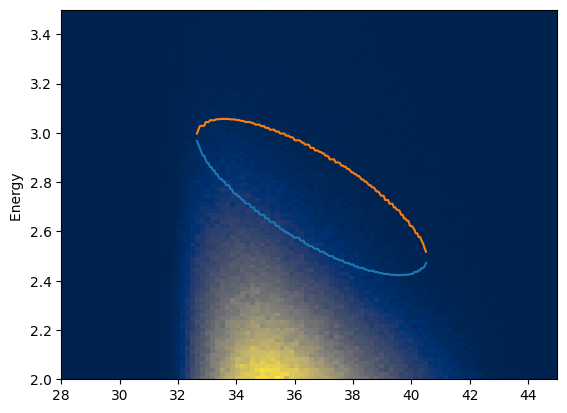

In [275]:
plt.plot(boundary_df["angles"],boundary_df["y_min"])
plt.plot(boundary_df["angles"],boundary_df["y_max"])
evsangle=plt.hist2d(etheta*180/math.pi,np.sqrt(.000511**2+trP**2),bins=((100,100)),range=((28,45),(2,3.5)),cmap="cividis")
plt.ylabel("Energy ")

# Quasi-Elastic Cuts 

In [276]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
nBins=CONFIG.Function_JSON("nBins",f"../config/cuts{config}.cfg")

#kin3
#dymin=-.7895
#dymax=.7895
#W2max=1.2
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-.5
#dxmax=.5
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'nBins: {nBins}')
#nBins=150
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
nBins: 100
Coin Min: 88 Coin Max: 100


In [277]:
data = np.loadtxt("angleEnergy.csv", delimiter=",", skiprows=1)
data2 = np.transpose(data)


# Apply the cut

In [278]:
ePS=generic['ePS']
eSH=generic['eSH']
trP=generic['trP']
etheta=generic['etheta']
dx=generic['dx']
W2=generic['W2']
dy=generic['dy']
coin=generic['coin_time']

In [279]:
import numpy as np

# Example arrays (replace with your actual data)
# angles = np.array([...])  # Input angles array
# data2 = np.array([...])  # Loaded 2D array from the CSV

# Valid range for angles
angle_min = np.min(angles)
angle_max = np.max(angles)

# Initialize lists to store min and max values for each angle
min_values = []
max_values = []

# Loop through each angle
for angle in etheta*180/math.pi:
    if angle < angle_min or angle > angle_max:
        # If the angle is out of range, set min and max to 0
        min_values.append(0)
        max_values.append(0)
    else:
        # Find the index of the closest value in data2[0]
        closest_index = np.argmin(np.abs(data2[0] - angle))
        
        # Get the corresponding min and max values
        min_value = data2[1, closest_index]
        max_value = data2[2, closest_index]
        
        # Append to the lists
        min_values.append(min_value)
        max_values.append(max_value)

# Convert to numpy arrays if needed
min_values = np.array(min_values)
max_values = np.array(max_values)

# Apply the cut (example usage)
# For instance, you could filter another array based on these min/max values
anglecut = (trP >= min_values) & (trP <= max_values)
# Output the resulting min/max values or the filtered indices
print("Min values:", min_values)
print("Max values:", max_values)


Min values: [2.6975     2.57441565 2.86139053 ... 2.42458429 2.57441565 2.44022042]
Max values: [3.03914157 2.96985843 3.0512859  ... 2.7125     2.96985843 2.77902067]


In [283]:
#cutEnergy=plt.hist2d(etheta[anglecut]*180/math.pi,trP[anglecut],range=((30,45),(0,5)),bins=100)

In [281]:
wcut=(W2 >= W2min) & (W2 <= W2max)
coincut=(coin >= coinmin) & (coin <= coinmax)
dycut=(dy >= dymin) & (dy <= dymax)

thenewcut=coincut & dycut & anglecut
theoldcut=coincut & dycut & wcut

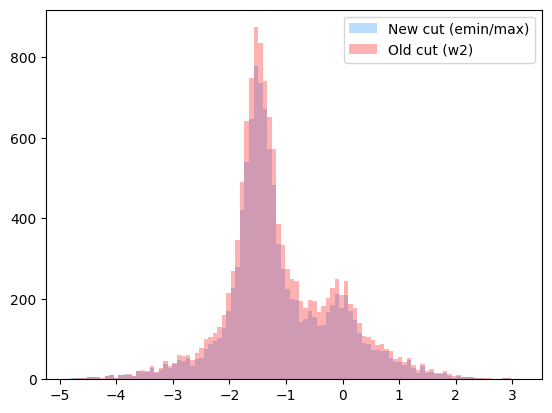

In [282]:
dxhistnew=plt.hist(dx[thenewcut],bins=100,color='dodgerblue',alpha=.3,label="New cut (emin/max)")
dxhistold=plt.hist(dx[theoldcut],bins=100,color='red',alpha=.3,label='Old cut (w2)')
plt.legend(loc='upper right')

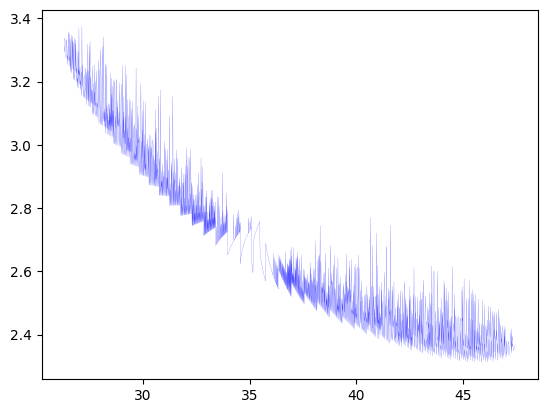

In [41]:
plt.plot(data2[0],data2[1], color='blue', label='Min', zorder=5,lw=.1)


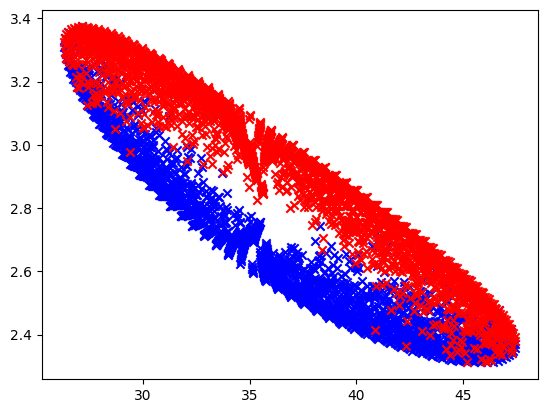

In [14]:
plt.scatter(data2[0],data2[1], color='blue', label='Min',marker='x', zorder=5)
plt.scatter(data2[0],data2[2], color='red', label='Max',marker='x', zorder=5)

In [4]:

# Create the data frame from the provided values
data = {
    "p_fermi": [0.075] * 11,
    "angle": [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    "min": [3.654, 3.521, 3.395, 3.274, 3.158, 3.048, 2.943, 2.842, 2.746, 2.654, 2.566],
    "max": [4.051, 3.915, 3.783, 3.657, 3.536, 3.419, 3.308, 3.201, 3.098, 3.000, 2.905]
}

df = pd.DataFrame(data)

# Perform interpolation for angle values between 30 and 40
interpolated_angles = np.linspace(30, 40, 100)

# Interpolating the min and max values
min_interp = np.interp(interpolated_angles, df['angle'], df['min'])
max_interp = np.interp(interpolated_angles, df['angle'], df['max'])

# Plot the interpolation
plt.figure(figsize=(10, 6))
plt.plot(interpolated_angles, min_interp, linestyle='--', color='blue')
plt.plot(interpolated_angles, max_interp, linestyle='--', color='red')

# Plot the actual points
plt.scatter(df['angle'], df['min'], color='blue', label='Min',marker='x', zorder=5)
plt.scatter(df['angle'], df['max'], color='red', label='Max',marker='x', zorder=5)
plt.fill_between(interpolated_angles, min_interp, max_interp, color='green', alpha=0.3, label='Cut Region')
# Add labels and title
plt.title('Interpolation of Angle Values with Actual Points Highlighted')
plt.xlabel('Electron Angle (degrees)')
plt.ylabel('Final Electron Energy (GeV)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [5]:
fileDIR=(f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
resolved_path = os.path.abspath(fileDIR)
print(f"Resolved Path: {resolved_path}")
print(f"File Exists: {os.path.exists(resolved_path)}")

Resolved Path: /home/research/GEn/GEn Data Analysis/outfiles/Pass1/QE_data_GEN3_sbs100p_nucleon_np_model2.root
File Exists: True


In [6]:
import ROOT as r


def list_branches(rootfile_path, tree_name="Tout"):
    # Open the ROOT file
    root_file = r.TFile.Open(rootfile_path)
    
    # Check if the file was successfully opened
    if not root_file or root_file.IsZombie():
        print(f"Error: Could not open ROOT file '{rootfile_path}'.")
        return
    
    # Access the TTree
    tree = root_file.Get(tree_name)
    
    # Check if the tree exists
    if not tree:
        print(f"Error: Tree '{tree_name}' not found in file '{rootfile_path}'.")
        root_file.Close()
        return
    
    # Get the list of branches
    branch_list = tree.GetListOfBranches()
    
    # Print all branch names
    print(f"Branches in tree '{tree_name}':")
    for branch in branch_list:
        print(branch.GetName())
    
    # Close the ROOT file
    root_file.Close()

# Example usage
rootfile_path = f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root"
list_branches(rootfile_path)


Branches in tree 'Tout':
runnum
WCut
pCut
nCut
fiduCut
coinCut
ebeam
nu
Q2
W2
dpel
ephi
etheta
pcentral
vz
vx
vy
xtgt
ytgt
thtgt
phtgt
thetabend
xfp
yfp
thfp
phfp
trP
trPx
trPy
trPz
ePS
xPS
eSH
xSH
ySH
eHCAL
xHCAL
yHCAL
xHCAL_exp
yHCAL_exp
dx
dy
ngrinch_hits
xGRINCH
yGRINCH
coin_time
hcal_time
bbcal_time
nhodo_clus
hodo_time
BPMAx
BPMAy
Rasterx
Rastery
Raster2x
Raster2y
helicity
IHWP


In [22]:
def EnergyAngle(config):
    C = TChain("Tout")
    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")

    C.Add(rootfilenp)

    
    
    # Disable all branches initially
    C.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time","trPx","trPy",
                "trPz,etheta"]
    
#for branch in branches:
    #    C.SetBranchStatus(branch, 1)
    
    
    C.SetBranchStatus("dx", 1)
    C.SetBranchStatus("dy", 1)
    C.SetBranchStatus("W2", 1)
    C.SetBranchStatus("trPx", 1)
    C.SetBranchStatus("trPy", 1)
    C.SetBranchStatus("trPz", 1)
    C.SetBranchStatus("etheta", 1)
    C.SetBranchStatus("coin_time", 1)
   
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    W2=array.array('d',[0])

    px=array.array('d',[0])
    py=array.array('d',[0])
    pz=array.array('d',[0])
    etheta=array.array('d',[0])
    coin=array.array('d',[0])
    
    
    # Set branch addresses
    C.SetBranchAddress("dx", dx)
    C.SetBranchAddress("dy", dy)
    C.SetBranchAddress("trPx", px)
    C.SetBranchAddress("trPy", py)
    C.SetBranchAddress("trPz", pz)
    C.SetBranchAddress("etheta", etheta)

    
    #C.SetBranchAddress("dy", dy_np)
    C.SetBranchAddress("W2", W2)
    #C.SetBranchAddress("helicity", helicity_np)
    #C.SetBranchAddress("IHWP", IHWP_np)
    C.SetBranchAddress("coin_time", coin)
    #C.SetBranchAddress("runnum", runnum_np)
    
    Entries=C.GetEntries()
    #Entries=100000
    energy=[]
    angle=[]
    energyCuts=[]
    angleCuts=[]
    dx_array=[]
    dy_array=[]
    energyCuts2=[]
    angleCuts2=[]
    dx_array2=[]
    dy_array2=[]
    for i in range(0,Entries):
        C.GetEntry(i)
        
        
        wcut=W2min<W2[0]<W2max
        dxcut=dxmin<dx[0]<dxmax
        dycut=dymin<dy[0]<dymax
        
        
        
        """########################EnergyCut##########################
        thisAngle=180/math.pi*etheta[0]
        
        closest_idx = np.argmin(np.abs(interpolated_angles - thisAngle ))
    
        interpAngle=interpolated_angles[closest_idx]
        min_val = min_interp[closest_idx]
        max_val = max_interp[closest_idx]
        
        bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
        hptotal=bigP
        hetotal=np.sqrt(bigP**2+.000511**2)
        
        energyCut=min_val<hetotal<max_val
        ########################EnergyCut##########################"""
        
        
        
        ########################EnergyCut##########################
        thisAngle=180/math.pi*etheta[0]
        
        closest_idx = np.argmin(np.abs(data2[0] - thisAngle ))
    
        interpAngle=data2[0][closest_idx]
        min_val = data2[1][closest_idx]
        max_val = data2[2][closest_idx]
        
        bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
        hptotal=bigP
        hetotal=np.sqrt(bigP**2+.000511**2)
        
        energyCut=min_val<hetotal<max_val
        ########################EnergyCut##########################
        
        coin_cut = coinmin < coin[0] < coinmax

        cut1=energyCut and coin_cut
        cut2=wcut and coin_cut
        
        
        
        
        
        
        
        
        
        if i % 10000 == 0 or i == Entries - 1:
                progress = f'Processing entry {i + 1}/{Entries} ({(i + 1) / Entries * 100:.2f}%)\r'
                sys.stdout.write(progress)
                sys.stdout.flush()
        
        
        energy.append(hetotal)
        angle.append(etheta[0])
        if cut1:
            bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
            hptotal=bigP
            hetotal=np.sqrt(bigP**2+.000511**2)
            energyCuts.append(hetotal)
            angleCuts.append(etheta[0])
            dx_array.append(dx[0])
            dy_array.append(dy[0])
        if cut2:
            bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
            hptotal=bigP
            hetotal=np.sqrt(bigP**2+.000511**2)
            energyCuts2.append(hetotal)
            angleCuts2.append(etheta[0])
            dx_array2.append(dx[0])
            dy_array2.append(dy[0])
            
            
            
    return [energy,np.array(angle)*180/math.pi,dx],[energyCuts,np.array(angleCuts)*180/math.pi,dx_array
                                                    ,dy_array],[energyCuts2,np.array(angleCuts2)*180/math.pi,dx_array2,dy_array2]

In [23]:
eaNoCuts,eaCuts1,eaCuts2=EnergyAngle(config)

In [24]:
energy_nc=eaNoCuts[0]
angle_nc=eaNoCuts[1]
dx1=eaCuts1[2]
dy1=eaCuts1[3]
energy_c=eaCuts1[0]
angle_c=eaCuts1[1]
dx2=eaCuts2[2]
dy2=eaCuts2[3]
energy_c=eaCuts2[0]
angle_c=eaCuts2[1]

In [30]:
dxHist=plt.hist(dx1,bins=70,alpha=.5,color='red',label="Energy Angle Cuts")
dxHist=plt.hist(dx2,bins=70,alpha=.5,color='dodgerblue',label="W2 Cuts")
plt.title("$\Delta$X Comparison with different Cuts")
plt.xlabel("$\Delta$X (m)")
plt.legend(loc='upper right')

In [21]:
angleenergyhist=plt.hist2d(angle_c,energy_c,bins=100,range=((30,40),(1,4.1)),cmap='inferno')
#plt.scatter(df['angle'], df['min'], color='white', label='Min',marker='x', zorder=5)
#plt.scatter(df['angle'], df['max'], color='yellow', label='Max',marker='x', zorder=5)
#plt.fill_between(interpolated_angles, min_interp, max_interp, color='white', alpha=0.3, label='Cut Region')
plt.xlabel("Electron Scattering Angle (theta)")
plt.ylabel("Final Electron Energy (GeV)")
plt.title("Final Energy vs Scattering Angle Dynamic Energy Cut")
plt.legend(loc='upper right')

NameError: name 'interpolated_angles' is not defined

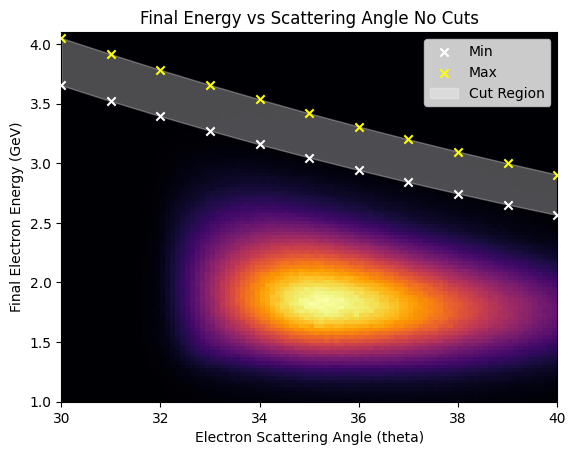

In [21]:
angleenergyhist=plt.hist2d(angle_nc,energy_nc,bins=100,range=((30,40),(1,4.1)),cmap='inferno')
#plt.scatter(df['angle'], df['min'], color='white', label='Min',marker='x', zorder=5)
#plt.scatter(df['angle'], df['max'], color='yellow', label='Max',marker='x', zorder=5)
plt.fill_between(interpolated_angles, min_interp, max_interp, color='white', alpha=0.3, label='Cut Region')
plt.xlabel("Electron Scattering Angle (theta)")
plt.ylabel("Final Electron Energy (GeV)")
plt.title("Final Energy vs Scattering Angle No Cuts")
plt.legend(loc='upper right')

# dx vs dy with w2 cut and then with energy cut

In [35]:
energycuthist=plt.hist2d(dy1,dx1,bins=100,range=((-3,3),(-4,3)),cmap='inferno')

plt.xlabel("dy")
plt.ylabel("dx")
plt.title("dx vs dy with energy cut")
plt.colorbar()

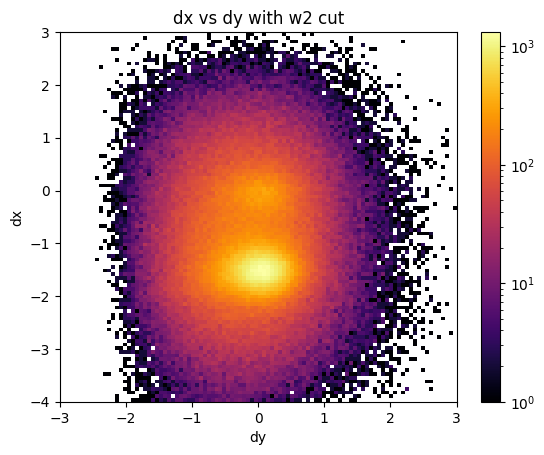

In [34]:
w2cuthist=plt.hist2d(dy2,dx2,bins=100,range=((-3,3),(-4,3)),cmap='inferno',norm=LogNorm())

plt.xlabel("dy")
plt.ylabel("dx")
plt.title("dx vs dy with w2 cut")
plt.colorbar()

In [31]:

def asymmetrySIMFIT(config,dynamic=0):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector=CONFIG.Function_JSON("GEN"+config,"../config/coin.cfg")
    he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
    he3spotsim=CONFIG.Function_JSON("GEN"+config+"He3sim","../config/spotsize.cfg")
    
    #here, set coincidence cut and spot cut values
    coinSigma=2.5
    coin_low=coinVector[0]-coinSigma*coinVector[1]
    coin_high=coinVector[0]+coinSigma*coinVector[1]

    #spot imports for dx,dy high and low
    
    hiydata=he3spot[1];
    lowydata=he3spot[0];
    
    hixdatan=he3spotsim[7];
    lowxdatan=he3spotsim[6];
    hixdatap=he3spotsim[5];
    lowxdatap=he3spotsim[4];
    
    hix_n_3 = he3spotsim[7]
    lowx_n_3 = he3spotsim[6]
    hix_p_3 = he3spotsim[5]
    lowx_p_3 = he3spotsim[4]
    hiy_p3 = he3spotsim[1]
    lowy_p3 = he3spotsim[0]
    hiy_n3 = he3spotsim[3]
    lowy_n3 = he3spotsim[2]
    

    rxn3 = (hix_n_3 - lowx_n_3) / 2.0
    rxp3 = (hix_p_3 - lowx_p_3) / 2.0
    ryp3 = (hiy_p3 - lowy_p3) / 2.0
    ryn3 = (hiy_n3 - lowy_n3) / 2.0



    x0_n3 = (hix_n_3 + lowx_n_3) / 2.0
    x0_p3 = (hix_p_3 + lowx_p_3) / 2.0
    y0_3 = (hiy_p3 + lowy_p3) / 2.0


    
    #-------------------------------------
    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfilep = (f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfileIn=f"../outfiles/Pass1/QE_Insim2_GEN{config}_sbs100p_nucleon_np_model2.root"
    rootfileIn=f"../outfiles/Pass1/QE_Insim2_GEN{4}_sbs100p_nucleon_np_model2.root"

    
    C = TChain("Tout")
    B = TChain("Tout")
    
    C.Add(rootfilenp)
    B.Add(rootfilep)
    D = TChain("Tout")
    D.Add(rootfileIn)
    D.SetBranchStatus("*", 0)
    
    px,py,pz = array.array('d', [0]),array.array('d', [0]),array.array('d', [0])
    
    dx_p, dy_p, W2_p, coin_p,fnucl,Q2  = array.array('d', [0]),array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np= array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    weight_In,dx_In,dy_In,W2_In,MC_sig=array.array('d', [0]),array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0])

    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time","Q2"]
    b2=["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)
        D.SetBranchStatus(branch, 1)
    
    C.SetBranchStatus("trPx", 1)
    C.SetBranchStatus("trPy", 1)
    C.SetBranchStatus("trPz", 1)
    
    C.SetBranchAddress("trPx", px)
    C.SetBranchAddress("trPy", py)
    C.SetBranchAddress("trPz", pz)
    
    B.SetBranchStatus("weight", 1)
    D.SetBranchStatus("weight", 1)
    D.SetBranchStatus("mc_sig",1)
    B.SetBranchStatus("fnucl",1)
    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    C.SetBranchAddress("Q2", Q2)
    B.SetBranchAddress("dx", dx_p)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    C.SetBranchAddress("helicity", helicity_np)
    #B.SetBranchAddress("helicity", helicity_p)
    C.SetBranchAddress("IHWP", IHWP_np)
    #B.SetBranchAddress("IHWP", IHWP_p)
    C.SetBranchAddress("coin_time", coin_np)
    #B.SetBranchAddress("coin_time", coin_pp)
    C.SetBranchAddress("runnum", runnum_np)
    #B.SetBranchAddress("runnum", runnum_p)
    B.SetBranchAddress("weight", weight)
    B.SetBranchAddress("fnucl", fnucl)
    D.SetBranchAddress("dx", dx_In)
    D.SetBranchAddress("dy", dy_In)
    D.SetBranchAddress("W2", W2_In)
    D.SetBranchAddress("weight", weight_In)
    D.SetBranchAddress("mc_sig",MC_sig)

    
    
    
    
    
    
    C.SetBranchStatus("etheta", 1)
    
   
    etheta=array.array('d',[0])
    
    
    
    # Set branch addresses
    
    C.SetBranchAddress("etheta", etheta)
    
    
    
    
    
    
    
    # Assuming the variables are already defined or loaded from the ROOT file
    nbins=nBins    
    xmin, xmax = -4, 2.5
    if config=="2":
        xmin=-5.5
        xmax=2.8
    hdx_bg_sim=r.TH1F("hdx_bg_sim","Inelastic Simulation 1d",nbins,xmin,xmax) 
    hdx_total_data = TH1F("hdx_total_data", "#Deltax;#Deltax;Entries", nbins, xmin, xmax)
    hdx_total_sim = TH1F("hdx_total_sim", "#Deltax;#Deltax;Entries", 100, -6, 4)
    hdx_p = TH1F("hdx_p", "#Deltax for helicity +1;#Deltax;Entries", 100, -6, 4)
    hdx_m = TH1F("hdx_m", "#Deltax for helicity -1;#Deltax;Entries", 100, -6, 4)
    
    hdx_data_plus = TH1F("hdx_data_plus", "", nbins, xmin, xmax)
    hdx_data_minus = TH1F("hdx_data_minus", "", nbins, xmin, xmax)
    hdx_sim_p = TH1F("hdx_sim_p", "", nbins, xmin, xmax)
    hdx_sim_n = TH1F("hdx_sim_n", "", nbins, xmin, xmax)
    hdx_bg_data = TH1F("hdx_bg_data", "", nbins, xmin, xmax)
    hdx_bg_data_plus = TH1F("hdx_bg_data_plus", "", nbins, xmin, xmax)
    hdx_bg_data_minus = TH1F("hdx_bg_data_minus", "", nbins, xmin, xmax)
    
    number=0
    nEntries_np = C.GetEntries()
    for i in range(nEntries_np):
        C.GetEntry(i)

        #if Q2[0]!=0:
        #    fractionQ2=abs(Q2[0]-Q2nominal)/Q2[0]
        #else:
        #    fractionQ2=0
        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue    
        
#____________CUTS_______________________________      
        if dynamic==1:
            ycut = dymin-dymin*fractionQ2 < dy_np[0] < dymax+dymax*fractionQ2
        if dynamic==0:
            ycut = dymin < dy_np[0] < dymax
        bgycut=dybgmin<dy_np[0]<dybgmax
        coin_cut = coinmin < coin_np[0] < coinmax
        W2cut=W2min < W2_np[0] < W2max
        """########################EnergyCut##########################
        thisAngle=180/math.pi*etheta[0]
        
        closest_idx = np.argmin(np.abs(interpolated_angles - thisAngle ))
    
        interpAngle=interpolated_angles[closest_idx]
        min_val = min_interp[closest_idx]
        max_val = max_interp[closest_idx]
        
        bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
        hptotal=bigP
        hetotal=np.sqrt(bigP**2+.000511**2)
        
        energyCut=min_val<hetotal<max_val
        ########################EnergyCut##########################"""
        
        
        
        ########################EnergyCut##########################
        thisAngle=180/math.pi*etheta[0]
        
        closest_idx = np.argmin(np.abs(data2[0] - thisAngle ))
    
        interpAngle=data2[0][closest_idx]
        min_val = data2[1][closest_idx]
        max_val = data2[2][closest_idx]
        
        bigP=np.sqrt(px[0]**2+py[0]**2+pz[0]**2)
        hptotal=bigP
        hetotal=np.sqrt(bigP**2+.000511**2)
        
        energyCut=min_val<hetotal<max_val
        ########################EnergyCut##########################
        
        
        
        
        
        
        
        
        
        
#________________________________________________     

        #if coin_cut and W2cut and runnum_np[0] > 2165 and not bgycut:
        if coin_cut and energyCut and runnum_np[0] > 2165 and not bgycut:
            hdx_bg_data.Fill(dx_np[0])
            if helicity_np[0] == 1:
                hdx_bg_data_plus.Fill(dx_np[0])
            if helicity_np[0] == -1:
                hdx_bg_data_minus.Fill(dx_np[0])

        #if coin_cut and W2cut and runnum_np[0] > 2165 and ycut:
        if coin_cut and energyCut and runnum_np[0] > 2165 and ycut:
            number+=1
            hdx_total_data.Fill(dx_np[0])
            if helicity_np[0] == 1:
                hdx_data_plus.Fill(dx_np[0])
            if helicity_np[0] == -1:
                hdx_data_minus.Fill(dx_np[0])
    
    # Simulation loop
    nEntries_p = B.GetEntries()
    
    for i in range(nEntries_p):
        B.GetEntry(i)
        

        #ncut = (dx_p[0] - x0_n3)**2 / rxn3**2 + (dy_p[0] - y0_3)**2 / ryn3**2 <= 1
        #pcut = (dx_p[0] - x0_p3)**2 / rxp3**2 + (dy_p[0] - y0_3)**2 / ryp3**2 <= 1
        ##temp testing-------------------------------
       # ycut = lowydata < dy_p[0] < hiydata
        #xcutn = lowxdatan < dx_p[0] < hixdatan
       # #xcutp = lowxdatap < dx_p[0] < hixdatap
        ######---------------------------------------
                
        #____________CUTS_______________________________      
        ycut = dymin < dy_p[0] < dymax
        
        
        
        W2cut=W2min < W2_p[0] < W2max
        
        
        
        #________________________________________________ 
        
        #temp replace pcut with ycut+xcut
        #print(fnucl)
        #if W2_p[0] < W2max and ycut and fnucl[0]==1:
        #    hdx_sim_p.Fill(dx_p[0], weight[0])
        #if W2_p[0] < W2max and ycut and fnucl[0]==0:
        #    hdx_sim_n.Fill(dx_p[0], weight[0])
        if W2cut and ycut and fnucl[0]==1:
            hdx_sim_p.Fill(dx_p[0], weight[0])
        if W2cut and ycut and fnucl[0]==0:
            hdx_sim_n.Fill(dx_p[0], weight[0])
    
    nEntries_In = D.GetEntries()
    for i in range(nEntries_In):
        D.GetEntry(i)
        
        #____________CUTS_______________________________      
        ycut = dymin < dy_In[0] < dymax
        W2cut = W2min < W2_In[0] < W2max
        #________________________________________________ 
        #if ycut:
        if W2cut:
            hdx_bg_data.Fill(dx_In[0],MC_sig[0]*1e28)

        #hdx_bg_sim.Fill(dx_In[0])

    # Fit distributions
    cfg = f"GEN{config}"
    print(cfg)
    
    dists = DistributionFits(bg_shape_option="pol4" if cfg == "GEN2" else "from data")
    dists.hdx_data = (np.array([hdx_total_data.GetBinCenter(i) for i in range(1, hdx_total_data.GetNbinsX() + 1)]), 
                      np.array([hdx_total_data.GetBinContent(i) for i in range(1, hdx_total_data.GetNbinsX() + 1)]))
    dists.hdx_sim_p = (np.array([hdx_sim_p.GetBinCenter(i) for i in range(1, hdx_sim_p.GetNbinsX() + 1)]), 
                       np.array([hdx_sim_p.GetBinContent(i) for i in range(1, hdx_sim_p.GetNbinsX() + 1)]))
    dists.hdx_sim_n = (np.array([hdx_sim_n.GetBinCenter(i) for i in range(1, hdx_sim_n.GetNbinsX() + 1)]), 
                       np.array([hdx_sim_n.GetBinContent(i) for i in range(1, hdx_sim_n.GetNbinsX() + 1)]))
    dists.hdx_bg_data = (np.array([hdx_bg_data.GetBinCenter(i) for i in range(1, hdx_bg_data.GetNbinsX() + 1)]), 
                         np.array([hdx_bg_data.GetBinContent(i) for i in range(1, hdx_bg_data.GetNbinsX() + 1)]))

    hdx_bg_fit, hdx_total_fit, hdx_sim_p, hdx_sim_n = dists.He3_fit_dists()
    # Plot results
    hdx_data_plot = hdx_total_data.Clone("hdx_data_plot")
    #hdx_sim_p_plot = hdx_sim_p.Clone("hdx_sim_p_plot")
    #hdx_sim_n_plot = hdx_sim_n.Clone("hdx_sim_n_plot")
    hdx_sim_p_plot = TH1F("hdx_sim_p_plot", "", nbins, xmin, xmax)
    hdx_sim_n_plot = TH1F("hdx_sim_n_plot", "", nbins, xmin, xmax)
    hdx_bg_plot = TH1F("hdx_bg_plot", "", nbins, xmin, xmax)
    hdx_total_fit_plot = TH1F("hdx_total_fit_plot", "", nbins, xmin, xmax)

    for i in range(nbins):
        hdx_bg_plot.SetBinContent(i + 1, hdx_bg_fit[i])
        hdx_total_fit_plot.SetBinContent(i + 1, hdx_total_fit[i])
        hdx_sim_p_plot.SetBinContent(i + 1, hdx_sim_p[i])
        hdx_sim_n_plot.SetBinContent(i + 1, hdx_sim_n[i])

    gStyle.SetOptFit(0)
    
    hdx_data_plot.SetTitle(f"Data/Simulation Comparison {cfg};#Deltax (m);Entries")
    hdx_data_plot.SetMarkerStyle(r.kFullCircle)
    hdx_total_fit_plot.SetFillColorAlpha(30, 0.5)
    hdx_sim_p_plot.SetFillColorAlpha(r.kRed, 0.3)
    hdx_sim_n_plot.SetFillColorAlpha(r.kBlue, 0.3)
    hdx_bg_plot.SetFillColorAlpha(r.kMagenta, 0.3)
    
    hdx_total_fit_plot.SetLineStyle(7)
    hdx_sim_p_plot.SetLineStyle(7)
    hdx_sim_n_plot.SetLineStyle(7)
    hdx_bg_plot.SetLineStyle(7)
    
    hdx_total_fit_plot.SetLineColor(30)
    hdx_sim_p_plot.SetLineColor(r.kRed)
    hdx_sim_n_plot.SetLineColor(r.kBlue)
    hdx_bg_plot.SetLineColor(r.kMagenta)
    
    c = TCanvas("c", "", 800, 600)
    hdx_data_plot.Draw()
    hdx_total_fit_plot.Draw("same hist")
    hdx_sim_p_plot.Draw("same hist")
    hdx_sim_n_plot.Draw("same hist")
    hdx_bg_plot.Draw("same hist")
    
    legend = TLegend(0.65, 0.72, 0.89, 0.89)
    legend.AddEntry("hdx_data_plot", "Data", "p")
    legend.AddEntry("hdx_total_fit_plot", "MC Fit", "lf")
    legend.AddEntry("hdx_sim_p_plot", "MC p", "lf")
    legend.AddEntry("hdx_sim_n_plot", "MC n", "lf")
    legend.AddEntry("hdx_bg_plot", "Background", "lf")
    legend.SetLineColor(0)
    legend.Draw("same")
    
    output = f"Data_sim_total_{cfg}.pdf"
    #c.SaveAs(f"../plots/{output}")
    print(f"events passing {number}")
    return Function_HIST2NP(hdx_data_plot), Function_HIST2NP(hdx_bg_plot),Function_HIST2NP(hdx_total_fit_plot),Function_HIST2NP(hdx_sim_p_plot),Function_HIST2NP(hdx_sim_n_plot)




# Run fit function and extract histograms

In [32]:
save=asymmetrySIMFIT(config,0)

GEN3
events passing 202444


Error in <TList::Clear>: A list is accessing an object (0xa2b3c20) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa949490) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xc93ca80) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xbf71020) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xad57c40) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa2b44d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa8577f0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa980400) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb37e2c0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x4ae50d0) alread

In [33]:
he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
hixdatan=he3spot[7];
lowxdatan=he3spot[6];

In [34]:
data,bgHist,totalHist,simpHist,simnHist = save

In [35]:
"""np.save(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy', {
    'data': data,
    'bgHist': bgHist,
    'totalHist': totalHist,
    'simpHist':simpHist,
    'simnHist':simnHist,
},allow_pickle=True)"""

"np.save(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy', {\n    'data': data,\n    'bgHist': bgHist,\n    'totalHist': totalHist,\n    'simpHist':simpHist,\n    'simnHist':simnHist,\n},allow_pickle=True)"

# Fit the neutron peak to determine quasicut

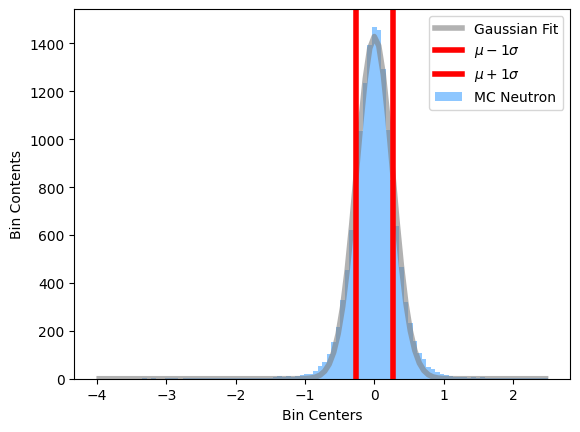

Mean: 0.0014, Standard Deviation (Sigma): 0.2601340718154978
Number of events within ±1 sigma: 9749.7632
dxmin: -0.259
dxmax: 0.262


In [36]:
bin_centers,bin_contents=simnHist
sigcut=1
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5, color="dodgerblue", label="MC Neutron")
x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, color='grey', linewidth=4,alpha=.6, label='Gaussian Fit')
plt.axvline(mean -sigcut * stddev, color='red', linewidth=4, label=f'$\mu - {sigcut}\sigma$')
plt.axvline(mean + sigcut * stddev, color='red', linewidth=4, label=f'$\mu + {sigcut}\sigma$')

plt.xlabel('Bin Centers')
plt.ylabel('Bin Contents')
plt.legend()
plt.show()
lower_bound = mean -sigcut * stddev
upper_bound = mean + sigcut * stddev

within_3sigma = np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
print(f"Mean: {np.round(mean,4)}, Standard Deviation (Sigma): {stddev}")
print(f"Number of events within ±{sigcut} sigma: {np.round(within_3sigma,4)}")
print(f'dxmin: {np.round(lower_bound,3)}')
print(f'dxmax: {np.round(upper_bound,3)}')

# Create pretty plot

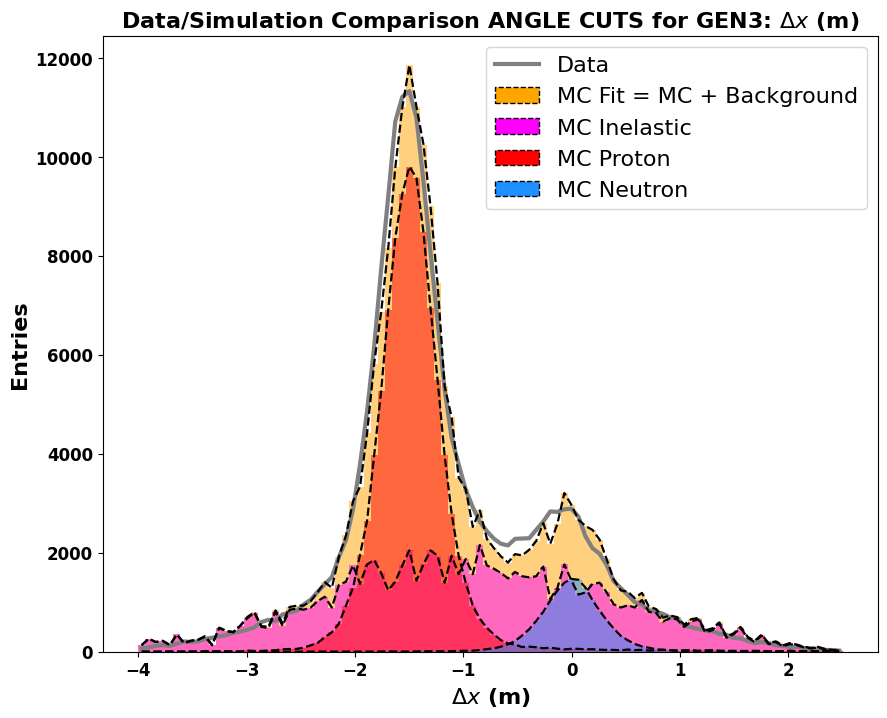

15011.584365800023

In [37]:
bin_centers,bin_contents=bgHist
plt.figure(figsize=(10,8))
lw=1.6
l=3
if config=="2":
    lw=1
    l=3
fs=16
fw='bold'

#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=l,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='magenta',label="Background Sim")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
typ="Background Data"
if config=="2":
    typ="4th Order Poly"
#_________________Special Legend Including Dotted Black Border______________________________________________
a=1
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='MC Inelastic', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________

#plt.axvline(dxmin, color='black', linewidth=3,ymax=.4, label=r'$\mu - 3\sigma$')
#plt.axvline(dxmax, color='black', linewidth=3,ymax=.4, label=r'$\mu + 3\sigma$')




#print(f'{upper} {lower}')
plt.title(f'Data/Simulation Comparison ANGLE CUTS for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)
plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
plt.show()
np.sum(bin_contents)

# EXTRA

In [11]:
s=16000
bg=16000

s/(np.sqrt(s+bg))

89.44271909999158

In [12]:
s=10000
bg=50000
s/(np.sqrt(s+bg))

40.8248290463863

In [13]:
np.sqrt(2000)

44.721359549995796